
# 🛰️ Mount Kenya Land Cover Classification using Natural Color Imagery
**Author:** Vincent Ogweno  
**Platform:** Google Colab  
**Objective:**  
This notebook demonstrates a complete land cover classification workflow for the Mount Kenya region. We use a natural color Landsat image and manually labeled training polygons to extract RGB features, train a Random Forest model, and classify the full image.


In [1]:

!pip install geopandas rasterio rasterstats scikit-learn matplotlib

from google.colab import drive
drive.mount('/content/drive')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 32.7 MB/s eta 0:00:00
Mounted at /content/drive


## 1. Load Training Polygons and Natural Color Raster

In [2]:

import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
from rasterstats import zonal_stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

shapefile_path = "/content/drive/MyDrive/GEE_exports1/mount_kenya_training_polygons.shp"
raster_path = "/content/drive/MyDrive/GEE_exports1/mount_kenya_truecolor_rgb.tif"

gdf = gpd.read_file(shapefile_path)
src = rasterio.open(raster_path)


## 2. Extract Mean RGB Values Under Training Polygons

In [3]:

stats = zonal_stats(vectors=gdf, raster=raster_path, stats=["mean"], band=1, prefix='R_')
features_df = pd.DataFrame(stats)

for band, prefix in [(2, 'G_'), (3, 'B_')]:
    stats = zonal_stats(gdf, raster_path, stats=["mean"], band=band, prefix=prefix)
    stats_df = pd.DataFrame(stats)
    features_df = pd.merge(features_df, stats_df, left_index=True, right_index=True)

features_df["landcover"] = gdf["landcover"]
features_df = features_df.dropna()
features_df.head()


/usr/local/lib/python3.11/dist-packages/rasterstats/io.py:335: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


,R_mean,G_mean,B_mean,landcover
0,0.790418,0.835508,0.788944,0
1,0.789879,0.836968,0.801982,0
2,0.803496,0.855254,0.807869,0
3,0.784292,0.835831,0.795331,0
4,0.859805,0.916952,0.835143,1


## 3. Train Random Forest Classifier

In [4]:

X = features_df[["R_mean", "G_mean", "B_mean"]].values
y = features_df["landcover"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

print("Training Accuracy:", clf.score(X_train, y_train))
print("Testing Accuracy:", clf.score(X_test, y_test))


Training Accuracy: 1.0
Testing Accuracy: 1.0


## 4. Apply Classifier to Full Image

In [5]:

with rasterio.open(raster_path) as src:
    img = src.read()
    profile = src.profile

rows, cols = img.shape[1], img.shape[2]
R, G, B = img[0].flatten(), img[1].flatten(), img[2].flatten()
pixel_data = np.stack((R, G, B), axis=-1)

mask = np.all(pixel_data > 0, axis=1)
pixel_data_clean = pixel_data[mask]

predictions = np.full(pixel_data.shape[0], -1)
predictions[mask] = clf.predict(pixel_data_clean)

classified = predictions.reshape((rows, cols))


## 5. Export Classified Raster

In [6]:

output_path = "/content/drive/MyDrive/GEE_exports1/classified_mount_kenya.tif"
profile.update(dtype=rasterio.uint8, count=1, compress='lzw')

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(classified.astype(rasterio.uint8), 1)

print("Classified raster saved to:", output_path)


Classified raster saved to: /content/drive/MyDrive/GEE_exports1/classified_mount_kenya.tif


## 6. Visualize Classified Image

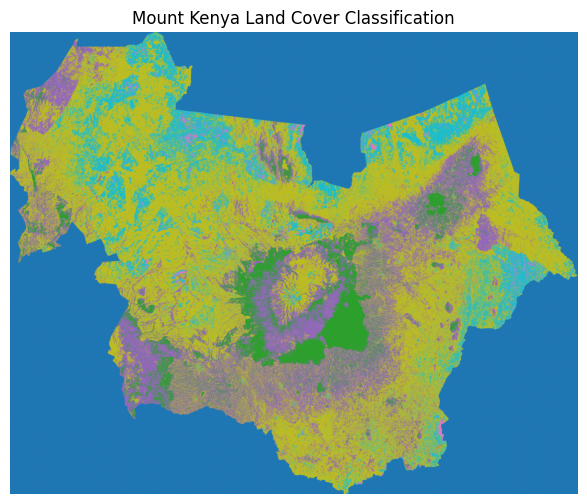

In [7]:

plt.figure(figsize=(10, 6))
plt.imshow(classified, cmap='tab10')
plt.title("Mount Kenya Land Cover Classification")
plt.axis('off')
plt.show()
